In [45]:
import os
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn import feature_selection, linear_model, cross_validation

pd.set_option('display.max_rows', 20)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 20)

%matplotlib inline
plt.style.use('ggplot')

## Import data

In [46]:
df = pd.read_csv(os.path.join('datasets', 'airbnb_train.csv'))
df.head()

,Unnamed: 0,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,0,gxn3p5htnn,2010-06-28,2009-03-19 04:32:55,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,1,820tgsjxq7,2011-05-25,2009-05-23 17:48:09,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,2,4ft3gnwmtx,2010-09-28,2009-06-09 23:12:47,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,3,bjjt8pjhuk,2011-12-05,2009-10-31 06:01:29,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,4,87mebub9p4,2010-09-14,2009-12-08 06:11:05,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [47]:
#convert to datetime type
df.date_account_created = pd.to_datetime(pd.to_datetime(df.date_account_created).dt.strftime("%Y-%m-%d"))
df.date_first_booking = pd.to_datetime(pd.to_datetime(df.date_first_booking).dt.strftime("%Y-%m-%d"))
df.timestamp_first_active = pd.to_datetime(pd.to_datetime(df.timestamp_first_active).dt.strftime("%Y-%m-%d"))

#remove hour, min, sec 
# df.timestamp_first_active = df.timestamp_first_active.apply(lambda datetime: datetime.date())
 
#drop id & unnamed column
df.drop(["id"], axis=1, inplace=True)
df.drop(["Unnamed: 0"], axis=1, inplace=True)

#drop nan
# df.dropna(inplace = True)
df.dropna(inplace = True, subset = ['date_account_created', 'timestamp_first_active', 'date_first_booking'])
df.head()

,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
2,2010-09-28,2009-06-09,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,2011-12-05,2009-10-31,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,2010-09-14,2009-12-08,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US
5,2010-01-01,2010-01-01,2010-01-02,-unknown-,NaN,basic,0,en,other,other,omg,Web,Mac Desktop,Chrome,US
6,2010-01-02,2010-01-02,2010-01-05,FEMALE,46.0,basic,0,en,other,craigslist,untracked,Web,Mac Desktop,Safari,US


In [48]:
df.dtypes

date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                               float64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## Time from first active to first booking

In [49]:
(df['date_first_booking'] - df['timestamp_first_active']).describe()


count                      88908
mean     44 days 16:36:44.022135
std      88 days 11:35:12.574019
min              0 days 00:00:00
25%              1 days 00:00:00
50%              3 days 00:00:00
75%             29 days 00:00:00
max           1369 days 00:00:00
dtype: object

## Time in hours:

In [8]:
# df['active_to_book'] = df.apply(lambda row: (row['date_first_booking'] - 
#                                              row['timestamp_first_active']).total_seconds()/3600.00, axis = 1)

In [9]:
df['active_to_book'] = df['date_first_booking'] - df['timestamp_first_active']

In [10]:
df.active_to_book.describe()

count                      88908
mean     44 days 16:36:44.022135
std      88 days 11:35:12.574019
min              0 days 00:00:00
25%              1 days 00:00:00
50%              3 days 00:00:00
75%             29 days 00:00:00
max           1369 days 00:00:00
Name: active_to_book, dtype: object

In [11]:
df.active_to_book.dtype

dtype('<m8[ns]')

In [12]:
df.active_to_book = (df.active_to_book / np.timedelta64(1, 'D'))

df.active_to_book.astype(int, inplace = True)


2          419
3         1043
4           72
5            1
6            3
7           10
8          206
9            0
10           2
12          13
          ... 
213407       0
213408       8
213409      12
213410     211
213412     207
213415       0
213439     259
213441      44
213443      13
213445       2
Name: active_to_book, dtype: int64

In [13]:
# df.active_to_book = df.active_to_book/(3600000*24)
# df.active_to_book


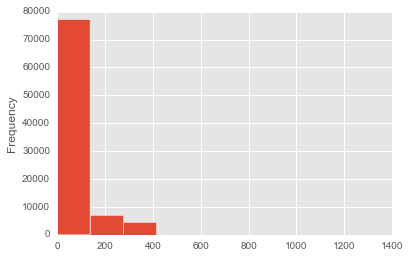

In [14]:
df.active_to_book.plot(kind="hist") 

In [15]:
df = df[df.active_to_book < 0]
df[ ['timestamp_first_active', 'date_first_booking', 'active_to_book' ]]

,timestamp_first_active,date_first_booking,active_to_book


In [16]:
# df = df[df.active_to_book > 0]


In [17]:
df[ ['timestamp_first_active', 'date_first_booking', 'active_to_book' ]].head()

,timestamp_first_active,date_first_booking,active_to_book


In [18]:
df['active_to_book'].value_counts()

Series([], Name: active_to_book, dtype: int64)

In [19]:
df.active_to_book.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: active_to_book, dtype: float64

In [20]:
df.age.describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: age, dtype: float64

In [21]:
df.age.value_counts()

Series([], Name: age, dtype: int64)

In [22]:
df.gender.value_counts()

Series([], Name: gender, dtype: int64)

In [23]:
#change direct or not direct
df.affiliate_channel.value_counts()

Series([], Name: affiliate_channel, dtype: int64)

In [24]:
#age categorical age vs variable looks like curve transform data into categorize 
#country_destination --> USA or Not 
#first_browser --> is chrome is not chrome
#histograms of individual colums type = hist especially useful for categorical variables 